In this jupyter notebook, we will check the responses collected online for completeness. 
Also, we will perform some basic sanity checks and preprocess the data.

We will first load the data from a json file and transform it into a pandas data frame. 
After that, we will run our checks for data inclusion. In the end, we will save two csv data frames (one per task) that contain only data we want to include into the analysis.

### Inclusion Criteria 
1. completeness (also controlled for online):

every participant has done the same number of trials

2. screen requirements (also controlled for online):

height and width support full stimulus presentation

orientation changes are only allowed when the screen is large enough

3. responses in survey

participants responded with the index finger

concentration rating at least neutral

fullscreen worked

no comments about missunderstanding etc.

4. data quality

for jump trials: the x touch coordinate is correlated with the x coordinate of the dot after the jump

for serial trials: touch position better explained by true location than by mean (response targeted dots)

## Part 0: load libraries and data

In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls

# custom library with functions for this script
from sanity_check_funcs import *

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# collect participant with weird behaviour
speed_participants = [] # participants with unusual experiment durations
portrait_participants = [] # participants that used portrait mode
unconcentrated_participants = [] # participants that reported a concentration below "neutral"
non_index_participants = [] # participants that used the wrong finger

In [2]:
data = {}
# load data from different components:

# the experimental component
exp_data =  open('../data/jatos_results_25_08.txt')
# unpack the data
for ses, jf in enumerate(exp_data):
    
    # save it to a data frame
    jd = json.loads(jf)
    df = pd.DataFrame(jd)
    df['session'] = ses

    try:
        data = pd.concat([data,df], axis = 0)
    except:
        data = df
data.reset_index(drop = True, inplace = True)
data

,view_history,rt,test_part,trial_type,trial_index,time_elapsed,internal_node_id,subject,screenWidth,screenHeight,...,touchOn,touchOff,choiceOrder,button-x,button-y,jump-x,jump-y,orderResponse,responses,survey_response
0,"[{""page_index"":0,""viewing_time"":9845}]",9846.0,general_welcome,instructions,0,9852,0.0-0.0,4285,375.0,812.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{""page_index"":0,""viewing_time"":2460},{""page_i...",11344.0,general_intro,instructions,1,21419,0.0-1.0,4285,375.0,812.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,7120.0,general_tablet,image-button-response,2,29565,0.0-2.0,4285,375.0,812.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,5592.0,general_phone,image-button-response,3,35165,0.0-3.0,4285,375.0,812.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{""page_index"":0,""viewing_time"":3136}]",3138.0,general_intro,instructions,0,3141,0.0-0.0,4285,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355,NaN,762.0,outro_finger,html-button-response,1,3451,0.0-0.0-1.0,4275,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,index
2356,NaN,1294.0,outro_screen,html-button-response,2,4753,0.0-0.0-2.0,4275,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
2357,NaN,2488.0,outro_hand,html-button-response,3,7248,0.0-0.0-3.0,4275,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
2358,NaN,6142.1,outro_comments,survey-text,4,13410,0.0-0.0-4.0,4275,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CK 1


The above data frame contains contains data from all components (the introduction, the training, the tasks, the survey in the end etc.) in the experiment.

Each single row represents one part of the study that was called with a particular plugin (e.g. the plugin for jump trials or serial trials). The component and the type of the event in the row are marked in the columns "component" and "test_part".

Each jsPsych plugin returns different variables, so when we put their outputs in one big data frame, we will have a lot of NaN values. In the section "Parse and filter the data", we will filter out rows from the components we need for our data analysis and drop columns that don't belong to the task.

But first, we load the meta data to our study.

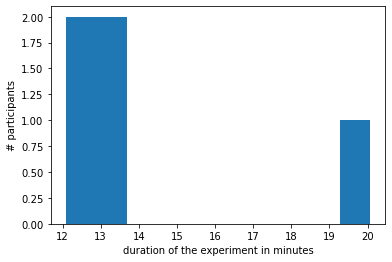

In [3]:
# Import jatos meta data
jatos_meta = pd.read_csv('../data/jatos_meta_25_08.csv')

# initialize a column in the meta data frame
jatos_meta['DurationSeconds'] = np.nan

# compute the duration in seconds
for i in jatos_meta.index:
    jatos_meta.loc[i, 'DurationSeconds'] = hhmmss_to_sec(jatos_meta['Duration'][i])

# find the outliers
speed_outlier = find_outliers(jatos_meta, 'DurationSeconds')

if len(speed_outlier)>1:
    print('{} participants did the experiment in an unusual time'.format(len(speed_outlier)))
    speed_participants.append(jatos_meta[speed_outlier, 'subject'])
    
# plot a histrogram of the durations
plt.hist(jatos_meta.DurationSeconds/60)
plt.xlabel('duration of the experiment in minutes')
plt.ylabel('# participants');

## Parse and filter the data 

In [4]:
# save a data frame for only the trials (exclude invalid trials, feedack, instruction etc.)
# jump data

# parse data frame into jdf and sdf                
jdf, sdf = parse_load_data(data, ['Trials_Jump', 'Trials_Serial'], jatos_meta)

# filter the data for trials that were actually shown (and not skipped)
# first, get only trials that were indeed shown
# refactor some old variables
sdf.loc[:,'test_part'] = sdf['test_part'].replace({'Serial-Inhibition': 'trial'})

# filter only data from trial components (omitting feedback lines)
j_dataTrial = filter_trials(jdf, {'test_part': 'trial'}) 
s_dataTrial = filter_trials(sdf, {'test_part': 'trial'}) 

# then, get those that were valid
j_data = filter_trials(jdf, {'lateResponse': False, 'earlyResponse': False})
s_data = filter_trials(sdf, {'lateResponse': False, 'orderResponse': True})

# get a list of participants
subjects = np.unique(data.subject)

# and compute the proportion of valid trials
for s in subjects:
    print('Subject {}:'.format(s))
    print('repeated {}% of jump trials.'.format((len(j_dataTrial[j_dataTrial.subject == s]) - len(j_data[j_data.subject == s]))*100/len(j_dataTrial[j_dataTrial.subject == s])))
    print('repeated {}% of serial trials.'.format((len(s_dataTrial[s_dataTrial.subject == s]) - len(s_data[s_data.subject == s]))*100/len(s_dataTrial[s_dataTrial.subject == s])))
    
## todo: visualize for each subject, how many trials they had to do how often (pie charts)

Subject 4275:
repeated 4.9504950495049505% of jump trials.
repeated 22.33009708737864% of serial trials.
Subject 4278:
repeated 3.0303030303030303% of jump trials.
repeated 11.11111111111111% of serial trials.
Subject 4280:
repeated 3.0303030303030303% of jump trials.
repeated 11.11111111111111% of serial trials.
Subject 4282:
repeated 4.0% of jump trials.
repeated 20.0% of serial trials.
Subject 4285:
repeated 6.796116504854369% of jump trials.
repeated 4.761904761904762% of serial trials.


## Part 1: check data for completeness

In [5]:
# completeness check

list_jump = []
list_serial = []

for s in subjects:
    
    # get the number of trials from each task
    jump = len(j_data[j_data.subject == s])
    serial = len(s_data[s_data.subject == s])
    
    # collect them in a list
    list_jump.append(jump)
    list_serial.append(serial)
    
    print('subject {} completed {} jump trials and {} serial trials'.format(s, jump, serial))

# check if all subjects did the same number of trials
print('there was one unique length of jump trials: {}'.format(len(np.unique(list_jump)) == 1))
print('there was one unique length of serial trials: {}'.format(len(np.unique(list_serial)) == 1))

subject 4275 completed 96 jump trials and 80 serial trials
subject 4278 completed 96 jump trials and 80 serial trials
subject 4280 completed 96 jump trials and 80 serial trials
subject 4282 completed 96 jump trials and 80 serial trials
subject 4285 completed 96 jump trials and 80 serial trials
there was one unique length of jump trials: True
there was one unique length of serial trials: True


## Part 2: check screen size requirements

In [6]:
# screen size check
# collect meta data
mdf = pd.DataFrame(columns = ['WidthCSS', 'HeightCSS',
                              'Device', 'Platform',
                              'scrPixDepth', 'scrColDepth', 'scrOrientation', 'scrResolution', 'subject'])

# the meta data is saved in different components. In the experimental component, 
# we saved meta information in the "welcome" part
# the welcome data frame
wdf = data[data.test_part == 'general_welcome']

for row,idx in enumerate(wdf.index):
    mdf.loc[row,'WidthCSS'] = max(wdf.screenWidth[idx], wdf.screenHeight[idx])
    mdf.loc[row,'HeightCSS'] = min(wdf.screenWidth[idx], wdf.screenHeight[idx])
    mdf.loc[row,'Device'] = wdf.userInfo[idx]
    mdf.loc[row,'Platform'] = wdf.platform[idx]
    mdf.loc[row,'scrPixDepth'] = wdf.scrPixDepth[idx]
    mdf.loc[row,'scrColDepth'] = wdf.scrColDepth[idx]
    mdf.loc[row,'scrOrientation'] = wdf.scrOrientation[idx]
    mdf.loc[row,'scrResolution'] = wdf.scrResolution[idx]
    mdf.loc[row,'subject'] = wdf.subject[idx]

# set min width
# set min height
min_width = 600
min_height = 300

print('All of the displays had at least the minimal width: {}'.format(np.all(mdf.WidthCSS >= min_width)))
print('All of the displays had at least the minimal height: {}'.format(np.all(mdf.HeightCSS >= min_height)))

All of the displays had at least the minimal width: True
All of the displays had at least the minimal height: True


In [7]:
# check if all the screen orientation was always landscape
# check the orientation - the experiment should be conducted in landscape mode

if len(s_data.scrOrientation == 'portrait') != 0 or len(j_data.scrOrientation == 'portrait') != 0:
    
    # get the participants
    portrait_serial = np.unique(s_data[s_data.scrOrientation == 'portrait'].subject)
    portrait_jump = np.unique(j_data[j_data.scrOrientation == 'portrait'].subject)
    # save all 
    portrait_participants = [item for sublist in [portrait_serial, portrait_jump] for item in sublist]
    portrait_participants = np.unique(portrait_participants)
    
    if len(portrait_participants) >= 1:
        # check if the screens of those participants was large enough
        for row in mdf.index:
            # get the participant that used portrait mode
            if mdf['subject'][row] in portrait_participants:
                # check if their screen size supprts that
                if mdf['WidthCSS'][row] >= min_height and mdf['HeightCSS'][row] >= min_width:

                    # remove this participant
                    portrait_participants = portrait_participants[portrait_participants != mdf['subject'][row]]
                
if len(portrait_participants) >= 1:
    print('subject {} used a non-suitable screen in portrait mode'. format(portrait_participants))

## Part 3: Check survey responses 

In [8]:
# collect survey data
survey_df = data[data.component == 'Outro_General']

In [9]:
# check if there are missing responses from a participant: 
for s in subjects: 
    
    if len(sdf[sdf.subject == s]) == 0:
        
        print('subject {} did not complete the survey'.format(s))

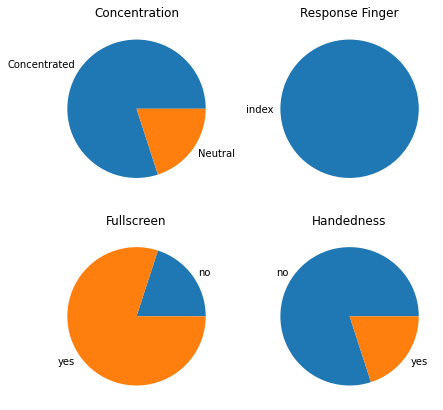

In [10]:
# check survey
# plot the distribution of responses in pie charts
# set up the figure
fig, axs = plt.subplots(2,2, figsize = (7,7))

# Question 1: "Indicate your concentration"
axs[0,0].set_title('Concentration')
concentration_rating = survey_df[survey_df.test_part == 'outro_concentration'].survey_response
parts_concentration, names_concentration = get_pie_parts(concentration_rating)
axs[0,0].pie(parts_concentration, labels = names_concentration)

# add unconcentrated participants to the list:
non_concentrated = ['Somewhat Distracted', 'Distracted']
unconcentrated_participants = survey_df[survey_df.test_part == 'outro_concentration'][concentration_rating.isin(non_concentrated)].subject

# Question 2: "Which finger did you use?"
axs[0,1].set_title('Response Finger')
response_finger = survey_df[survey_df.test_part == 'outro_finger'].survey_response
parts_finger, names_finger = get_pie_parts(response_finger)
axs[0,1].pie(parts_finger, labels = names_finger)

# add participants that used the wrong finger
non_index_participants = survey_df[survey_df.test_part == 'outro_finger'][response_finger != 'index'].subject

# Question 3: "Did the screen switch to fullscreen?"
axs[1,0].set_title('Fullscreen')
parts_screen, names_screen = get_pie_parts(survey_df[survey_df.test_part == 'outro_screen'].survey_response)
axs[1,0].pie(parts_screen, labels = names_screen)

# Question 4: "Which hand did you use?"
axs[1,1].set_title('Handedness')
parts_hand, names_hand = get_pie_parts(survey_df[survey_df.test_part == 'outro_hand'].survey_response)
axs[1,1].pie(parts_hand, labels = names_hand);

In [11]:
# Print all the comments that were given
print('comments: ')
print(survey_df[survey_df.test_part == 'outro_comments'].survey_response.dropna())

comments: 
459                  all good :)
941     Tablet upright landscape
1407             portrait tablet
1868             portrait tablet
2358                        CK 1
Name: survey_response, dtype: object


In [12]:
jumpColumns = ['subject','trialID', 'rt', 'mt', 'tDur', 'cTouchX', 'cTouchY','sTouchX', 'sTouchY', 
               'startTime', 'endTime', 'goSignalTime', 'goTime', 'waitTime',
               'sideX','sideY', 'centralX', 'centralY', 'jumpedX', 'jumpedY', 'offTouches',
               'windowHeight', 'windowWidth', 'scrOrientation',
               'position', 'stimJumped', 'flashShown', 'inwards', 
               'fixTime', 'flashTime', 'trialDuration', 'flashOnTime', 'flashOffTime', 'respTime']

j_data = j_data[jumpColumns]

serialColumns = ['subject','trialID', 'touchX', 'touchY', 'button-x', 'button-y', 'jump-x', 'jump-y',
                 'windowHeight', 'windowWidth', 'scrOrientation',
                 'tDur', 'startTime', 'endTime', 'waitTime', 'flashTime', 'offTouches',  
                 'flashOnTime', 'flashOffTime','touchOn', 'touchOff', 'stimJumped']

s_data = s_data[serialColumns]

# compute the movement onsets relative to the start of each trial

# define the columns that contain timing information
jump_timing = ['startTime', 'endTime', 'goTime','fixTime', 'flashOnTime', 'flashOffTime', 'respTime']
# apply alignment to jump data
df_jump = relate_to_onset(j_data.copy(), jump_timing, 'goSignalTime')

# add one column that indicates the onset relative to the flash
df_jump['goAfterFlashTime'] = df_jump['goTime'] - df_jump['flashOnTime']

# repeat for serial data
serial_timing = ['endTime', 'waitTime', 'flashOnTime', 'flashOffTime','touchOn', 'touchOff']
df_serial = relate_to_onset(s_data.copy(), serial_timing, 'startTime')
# reverse the order of buttons
for x in df_serial.index:
    df_serial['button-x'][x].reverse()
    df_serial['button-y'][x].reverse() 
    df_serial['jump-x'][x].reverse() 
    df_serial['jump-y'][x].reverse() 

In [13]:
# express the positions on the screen relative to the screen center
# javascript reads out the position of objects on their upper left corner
# this results in a 25 pixel shift (to get to the center of each dot, we need to add 25 pixels to the x and the y component)
# this is equivalent to substracting 25 pixel from the screen center            
# define how much we need to shift the center to get from the upper left corner to the center of a stimulus
upleft_to_center = 25  

# align to jumped data
# the targets on the screen (need shifting)
df_jump = align_to_center(df_jump, ['sideX','sideY', 'centralX', 'centralY', 'jumpedX', 'jumpedY'], shift = upleft_to_center)
# the touch responses (don't need shifting)
df_jump = align_to_center(df_jump, ['cTouchX', 'cTouchY','sTouchX', 'sTouchY'])

In [14]:
# remove outliers
# all touch responses that were more than 3 sd away from the average response will be removed.
# get all outlier indeces
rm_idx = remove_outliers(df_jump, ['cTouchX', 'cTouchY','sTouchX', 'sTouchY'])
# save the data we want to remove from the original df
df_jump_droptrials = df_jump.loc[rm_idx, :]
# remove outlier data
df_jump.drop(rm_idx, inplace = True)

# print total number of removed trials
print('{} trials were dropped due to imprecise answers'.format(len(rm_idx)))

9 trials were dropped due to imprecise answers


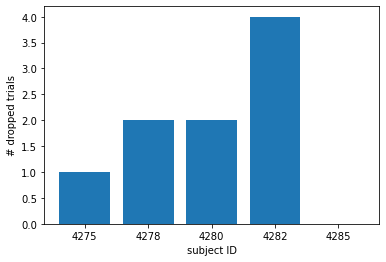

In [15]:
# visualize the number of dropped trials per subject
# compute the number of dropped trials per subject
subject_bars = [len(df_jump_droptrials[df_jump_droptrials.subject == s]) for s in subjects]

# plot
plt.bar(subjects, subject_bars)
plt.xlabel('subject ID')
plt.ylabel('# dropped trials');

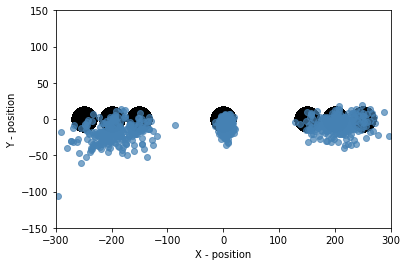

In [16]:
# plot all responses together (sanity check if they are all aligned)

plt.xlim(-300, 300)
plt.ylim(-150, 150)

plt.scatter(df_jump.centralX, df_jump.centralY, s=600, c = 'black')
plt.scatter(df_jump.cTouchX, df_jump.cTouchY, c = 'steelblue', alpha = 0.7)
plt.scatter(df_jump.jumpedX, df_jump.jumpedY, s=600, c = 'black')
plt.scatter(df_jump.sTouchX, df_jump.sTouchY, c = 'steelblue', alpha = 0.7)

plt.xlabel('X - position')
plt.ylabel('Y - position');

## Part 4.1: Quality control jump task

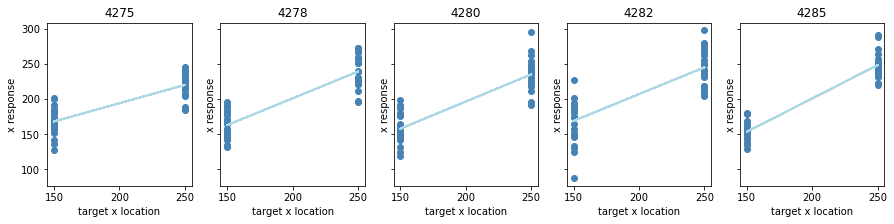

In [17]:
# Check data quality jump:
# compute the x error relative to the jumped dot
# check the regression       
OLS = check_xdot_xtouch_correlation(subjects, df_jump)

## Part 4.2: Quality control serial tasks

In [18]:
# transform the serial data set to one column for each button touch
# initialize lists fro the columns
X_touch_colnames = [] 
Y_touch_colnames = []
X_target_colnames = []
Y_target_colnames = []
time_colnames = []
lift_colnames = []

# for all targets that will be touched
for tar in range(0,6):
    
    timeOn_name = 'touchOnTime_tar{}'.format(tar)
    x_touch_name  = 'touchX_tar{}'.format(tar)
    y_touch_name  = 'touchY_tar{}'.format(tar)
    x_target_name = 'targetX_tar{}'.format(tar)
    y_target_name = 'targetY_tar{}'.format(tar)
    
    # add these names to their lists 
    X_touch_colnames.append(x_touch_name)
    Y_touch_colnames.append(y_touch_name)
    X_target_colnames.append(x_target_name)
    Y_target_colnames.append(y_target_name)
    time_colnames.append(timeOn_name)
    
    # extract lists of each
    timeOn_tar = [df_serial.touchOn[x][tar] for x in df_serial.index]
    X_touch = [df_serial.touchX[x][tar] for x in df_serial.index] 
    Y_touch = [df_serial.touchY[x][tar] for x in df_serial.index] 
    X_target = [df_serial['button-x'][x][tar] for x in df_serial.index] 
    Y_target = [df_serial['button-y'][x][tar] for x in df_serial.index] 
    
    # save in df
    df_serial[timeOn_name] = timeOn_tar
    df_serial[x_touch_name] = X_touch
    df_serial[y_touch_name] = Y_touch
    df_serial[x_target_name] = X_target
    df_serial[y_target_name] = Y_target
    
    # align to screen center
    # define how much we need to shift the center to get from the upper left corner to the center of a stimulus
    upleft_to_center = 25  

    # the targets on the screen (need shifting)
    df_serial = align_to_center(df_serial, [x_target_name, y_target_name], shift = upleft_to_center)
    # the touch responses (don't need shifting)
    df_serial = align_to_center(df_serial, [x_touch_name, y_touch_name])
    
    # lift times will be tracked for the first 5 lifts
    if tar < 5:
        timeOff_name = 'touchOff_time_{}'.format(tar)
        lift_colnames.append(timeOff_name)
        
        timeOff_tar = [df_serial.touchOff[x][tar] for x in df_serial.index]
        
        df_serial[timeOff_name] = timeOff_tar

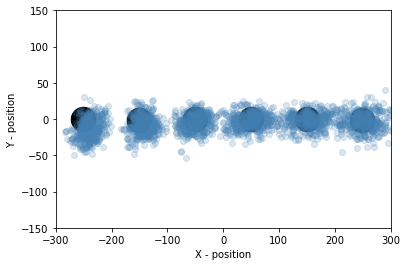

In [19]:
# plot the responses
for tar_x, tar_y, touch_x, touch_y in zip(X_target_colnames, Y_target_colnames, X_touch_colnames, Y_touch_colnames):
    
    plt.xlim(-300, 300)
    plt.ylim(-150, 150)

    plt.scatter(df_serial[tar_x].mean(), df_serial[tar_y].mean(), s=600, c = 'black')
    plt.scatter(df_serial[touch_x], df_serial[touch_y], c = 'steelblue', alpha = 0.2)
    
    plt.xlabel('X - position')
    plt.ylabel('Y - position');

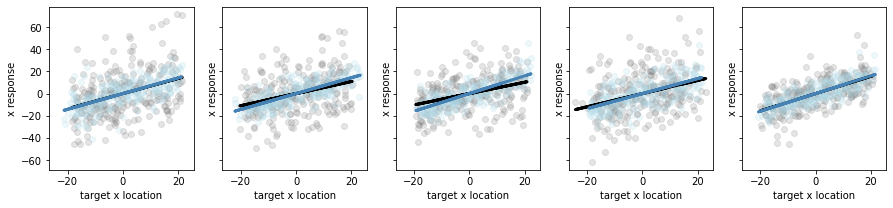

In [20]:
# Sanity check: the if touch coordinates are correlated with the position of each dot. 

# step 1: only data without a step
df_nojump = df_serial[df_serial['stimJumped'] == 0.0]

# run the check
OLS_x, OLS_y = check_touch_target_correlation(subjects, df_nojump, X_target_colnames, Y_target_colnames, X_touch_colnames, Y_touch_colnames)

In [23]:
# Finally: do we need to exclude any participants:

for p_list in [speed_participants, portrait_participants, unconcentrated_participants, non_index_participants]:
    
    print(len(p_list))

0
0
0
0
